<a href="https://colab.research.google.com/github/princessivy/Analyzing_CSGO_SkinPrices/blob/main/CSGO_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [1]:
import pandas as pd
import requests
import json

from google.colab import drive
from pathlib import Path

from PIL import Image
import requests
import cv2
import numpy as np

import time

#Daten einlesen

In [17]:
data = pd.read_csv(r'/content/drive/MyDrive/SA_BA/Data/allitems_w_colors.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (35) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [18]:
data.head()

,id,saleId,productId,assetId,itemId,appid,steamid,url,family,family_localized,...,collection,collection_localized,stickers,canHaveScreenshots,screenshots,souvenir,stattrak,tags,ownItem,colorfulness
0,0,6909421,5523872,46917102,9191,730,76561198837929747,bayonet-tiger-tooth-factory-new,Tiger Tooth,Tiger Tooth,...,NaN,NaN,[],True,"['playside', 'backside', 'image']",False,False,"[{'name': '★', 'name_localized': '★'}, {'name'...",False,59.790243
1,0,7653740,6120295,60753316,10318,730,76561198837492108,stattrak-bayonet-tiger-tooth-factory-new,Tiger Tooth,Tiger Tooth,...,NaN,NaN,[],True,"['playside', 'backside', 'image']",False,True,"[{'name': '★', 'name_localized': '★'}, {'name'...",False,57.181995
2,0,6835166,5463330,55716802,9191,730,76561198838929253,bayonet-tiger-tooth-factory-new,Tiger Tooth,Tiger Tooth,...,NaN,NaN,[],True,"['playside', 'backside', 'image']",False,False,"[{'name': '★', 'name_localized': '★'}, {'name'...",False,58.160273
3,0,5746569,4614623,43496004,9191,730,76561198837990201,bayonet-tiger-tooth-factory-new,Tiger Tooth,Tiger Tooth,...,NaN,NaN,[],True,"['playside', 'backside', 'image']",False,False,"[{'name': '★', 'name_localized': '★'}, {'name'...",False,58.489647
4,0,7664927,6129355,60829717,9191,730,76561198837298247,bayonet-tiger-tooth-factory-new,Tiger Tooth,Tiger Tooth,...,NaN,NaN,[],True,"['playside', 'backside', 'image']",False,False,"[{'name': '★', 'name_localized': '★'}, {'name'...",False,60.797777


#Beschreibung der Features
Der rohe Datensatz enthält die folgenden Features:

In [19]:
data.columns

Index(['id', 'saleId', 'productId', 'assetId', 'itemId', 'appid', 'steamid',
       'url', 'family', 'family_localized', 'name', 'title', 'text',
       'marketName', 'marketHashName', 'color', 'bgColor', 'image', 'classid',
       'assetid', 'lock', 'version', 'versionType', 'stackAble',
       'suggestedPrice', 'salePrice', 'currency', 'saleStatus', 'saleType',
       'category', 'category_localized', 'subCategory',
       'subCategory_localized', 'pattern', 'finish', 'customName', 'wear',
       'link', 'type', 'exterior', 'quality', 'rarity', 'rarity_localized',
       'rarityColor', 'collection', 'collection_localized', 'stickers',
       'canHaveScreenshots', 'screenshots', 'souvenir', 'stattrak', 'tags',
       'ownItem', 'colorfulness'],
      dtype='object')

Folgende Tabelle erklärt die Bedeutung der einzelnen Features:

Feature | Bedeutung
--- | ---
id | wurde nicht herausgefunden, ist stetig '0'
saleId | eindeutige Verkaufs-ID
productId | eindeutige Produkt-ID
assetId | eindeutige Asset-ID
itemId| itemspezifische ID
appid | Zuordnung zur Applikation CS:GO, ist stetig '730'
steamid | KP??
url | spezifischer Bestandteil der gesamten URL für das Item
family | zugehörige Familie des Items (Unterunterkategorie)
family_localized | wie 'family' nur übersetzt in Sprache der Abfrage (hier: weiterhin englisch)
name | Anzeigename auf Skinport
title | angezeigte Unterkategorie zu jedem Item
text | kurze Beschreibung zum Item
marketName | Zusammensetzung aus 'title' und 'name'
marketHashName | wurde nicht herausgefunden, ähnlich zu 'marketName'
color | 4 Farben?! :D
bgColor | Wert nicht gepflegt, durchgehend 'NaN'
image | mit Ergänzung "https://steamcommunity-a.akamaihd.net/economy/image/" vor dem Wert, gelangt man an ein standardisiertes Cover-Bild des Items
classid | wurde nicht herausgefunden
assetid | weitere eindeutige Asset-ID
lock | Zeigt, ab wann Item zum Spieleinsatz freigegeben ist ('NaN' bedeutet, dass ein direkter Einsatz möglich ist)
version | verschiedene Doppler-Phasen von CS:GO
versionType | Zuordnung der 'version's in übergeordnete Kategorie
stackAble | wurde nicht herausgefunden, ist stetig 'False'
suggestedPrice | Wertvorschlag des Preises von Skinport
salePrice | Kaufpreis des Items
currency | Währung, ist stetig 'EUR'
saleStatus | gibt an, ob Item verkaufbar ist; ist stetig 'listed' und somit verkaufbar
saleType | gibt an, wer einen Kauf machen kann; ist stetig 'public' und somit für alle zugänglich
category | Überkategorie
category_localized | wie 'category' nur übersetzt in Sprache der Abfrage (hier: weiterhin englisch)
subCategory | Unterkategorie
subCategory_localized | wie 'subCategory' nur übersetzt in Sprache der Abfrage (hier: weiterhin englisch)
pattern | Musternummer des Items (zwischen 1 und 1000)
finish | Finish des Items
customName | Name des Items, von einem Besitzer hinzugefügt
wear | Abnutzung (zwischen 0 und 1)
link | wurde nicht herausgefunden
type | Typ des Items
exterior | Kategorie der Abnutzung, je nach 'wear'
quality | Kategorie der Qualität
rarity | Kategorie der Rarität
rarity_localized | wie 'rarity' nur übersetzt in Sprache der Abfrage (hier: weiterhin englisch)
rarityColor | Farbkategorie der Rarität
collection | Kollektion 
collection_localized | wie 'collection' nur übersetzt in Sprache der Abfrage (hier: weiterhin englisch)
stickers | Array mit Stickern, welche sich auf dem Item befinden
canHaveScreenshots | gibt an, ob Screenshots zum Item existieren; ist stetig 'True'
screenshots | gibt an, welche Screenshots zum Item existieren
souvenir | gibt an, ob das Item ein Souvenir ist oder nicht
stattrak | gibt an, ob das Item Stattrak-Eigenschaft hat oder nicht
tags | angegebene Tags auf Skinport
ownItem | gibt an, ob das Item unter Besitz steht; ist stetig 'False'
colorfulness | gibt die Farbintensität eines Skins an; umso höher, desto farbiger (Feature wurde zuvor berechnet)

Nun werden einige Features entfernt, die unbrauchbar sind. Nähere Erläuterung in Kapitel X der Seminararbeit.
(wenn immer nur gleicher Wert, können die auch weg, weil Varianz gleich;; wenn alle unterschiedlich sind, bringt das auch nix)

In [20]:
data = data.drop(['id', 'saleId', 'productId', 'itemId', 'assetId', 'appid', 'steamid', 'url', 'family_localized', 'name', 'title', 'text', 'marketName', 'marketHashName', 'bgColor',
                  'image', 'classid', 'assetid', 'stackAble', 'currency', 'saleStatus', 'saleType', 'category_localized', 'subCategory_localized',
                  'customName', 'link', 'rarity_localized', 'collection_localized', 'canHaveScreenshots', 'screenshots', 'tags', 'ownItem'], 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
data.columns

Index(['family', 'color', 'lock', 'version', 'versionType', 'suggestedPrice',
       'salePrice', 'category', 'subCategory', 'pattern', 'finish', 'wear',
       'type', 'exterior', 'quality', 'rarity', 'rarityColor', 'collection',
       'stickers', 'souvenir', 'stattrak', 'colorfulness'],
      dtype='object')

In [22]:
len(data.columns)

22

#Explorative Datenanalyse
Eindruck über die Daten:

In [23]:
data.head()

,family,color,lock,version,versionType,suggestedPrice,salePrice,category,subCategory,pattern,...,type,exterior,quality,rarity,rarityColor,collection,stickers,souvenir,stattrak,colorfulness
0,Tiger Tooth,#8650AC,NaN,default,default,39721,39913,Knife,Bayonet,168.0,...,★ Covert Knife,Factory New,★,Covert,#eb4b4b,NaN,[],False,False,59.790243
1,Tiger Tooth,#8650AC,2022-04-02T07:00:00.000Z,default,default,44203,36244,Knife,Bayonet,972.0,...,★ StatTrak™ Covert Knife,Factory New,★ StatTrak™,Covert,#eb4b4b,NaN,[],False,True,57.181995
2,Tiger Tooth,#8650AC,NaN,default,default,39721,40000,Knife,Bayonet,455.0,...,★ Covert Knife,Factory New,★,Covert,#eb4b4b,NaN,[],False,False,58.160273
3,Tiger Tooth,#8650AC,NaN,default,default,39721,42073,Knife,Bayonet,397.0,...,★ Covert Knife,Factory New,★,Covert,#eb4b4b,NaN,[],False,False,58.489647
4,Tiger Tooth,#8650AC,2022-04-03T07:00:00.000Z,default,default,39721,35500,Knife,Bayonet,627.0,...,★ Covert Knife,Factory New,★,Covert,#eb4b4b,NaN,[],False,False,60.797777


Datentypen angucken. Wichtige Unterscheidung zwischen numerischen und kategorialen Features:

In [24]:
data.dtypes

family             object
color              object
lock               object
version            object
versionType        object
suggestedPrice      int64
salePrice           int64
category           object
subCategory        object
pattern           float64
finish            float64
wear              float64
type               object
exterior           object
quality            object
rarity             object
rarityColor        object
collection         object
stickers           object
souvenir             bool
stattrak             bool
colorfulness      float64
dtype: object

Numerisch:
- suggestedPrice
- salePrice
- pattern
- finish
- wear
- colorfulness

Kategorisch:
- family
- color
- lock
- version
- versionType
- category
- subCategory
- type
- exterior
- quality
- rarity
- rarityColor
- collection
- stickers
- souvenir
- stattrak


####Missing-Values

In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133005 entries, 0 to 133004
Data columns (total 22 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   family          133005 non-null  object 
 1   color           133005 non-null  object 
 2   lock            29404 non-null   object 
 3   version         133005 non-null  object 
 4   versionType     133005 non-null  object 
 5   suggestedPrice  133005 non-null  int64  
 6   salePrice       133005 non-null  int64  
 7   category        133005 non-null  object 
 8   subCategory     133005 non-null  object 
 9   pattern         132989 non-null  float64
 10  finish          132838 non-null  float64
 11  wear            133005 non-null  float64
 12  type            133005 non-null  object 
 13  exterior        133005 non-null  object 
 14  quality         133005 non-null  object 
 15  rarity          133005 non-null  object 
 16  rarityColor     133005 non-null  object 
 17  collection

In [26]:
data.shape

(133005, 22)

In [27]:
data = data.drop_duplicates()

In [28]:
data.shape #es gibt keine Duplikate

(133005, 22)

In [29]:
data.isnull().sum()

family                 0
color                  0
lock              103601
version                0
versionType            0
suggestedPrice         0
salePrice              0
category               0
subCategory            0
pattern               16
finish               167
wear                   0
type                   0
exterior               0
quality                0
rarity                 0
rarityColor            0
collection          4680
stickers               0
souvenir               0
stattrak               0
colorfulness           0
dtype: int64

In den Features *lock, pattern, finish* und *collection* finden sich Null-Werte. Diese werden nun behandelt. 

**lock** Bei *lock* geht es darum, ob die Items nach dem Kauf direkt zum Spiel einsetzbar sind: Ja oder Nein. Ein 'NaN' steht in diesem Fall für "ja"(1), eine Zeitangabe für "nein"(0). Entsprechend entsteht hieraus ein Boolean.  
(Dauer: 2 Minuten)

In [30]:
for x in range(len(data)):
  try:
    if np.isnan(data.lock[x]):
      data.lock[x] = 0
  except:
    data.lock[x] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


**pattern** Die fehlenden Werte lassen sich hier nicht einfach durch Binärisierung oder Imputation lösen. Solche Annahmen über das Pattern würden die Daten eher verfälschen. Da es sich bei den 16 fehlenden Werten um einen Anteil von 0,012% handelt, werden diese hiermit aus dem Datensatz entfernt.

In [31]:
data.shape

(133005, 22)

In [32]:
data = data[data['pattern'].notna()]

In [33]:
data.shape

(132989, 22)

**finish** Selbes Vorgehen wie bei *pattern*. Der Anteil, gemessen an der neuen Datenbasis, liegt bei 0,126%.

In [34]:
data = data[data['finish'].notna()]

In [35]:
data.shape

(132822, 22)

In [36]:
#Index wieder richten
data = data.reset_index()

**collection** Die Items, die keiner Kollektion zugeordnet sind, werden zur Kollektion "No Collection" umbenannt und bilden somit eine weitere Kategorie.

In [37]:
 data['collection'] = data['collection'].fillna("No Collection")

####Datentypenanpassung
*suggestedPrice* und *salePrice* sollten float's sein. Die Trennung zwischen Euros und Cents fehlt. Diese Variablen werden durch 100 geteilt, um dies zu lösen

In [38]:
data['salePrice'] = data['salePrice']/100
data['suggestedPrice'] = data['suggestedPrice']/100

*pattern* liegt zwischen 1 und 1000. Dabei handelt es sich nicht um einen float-Wert. Dieser Wert wird auf int gecastet.

In [39]:
data = data.astype({"pattern": int})

*finish* ist ebenso ein float, welcher eigentlich einem int enstpricht. Deshalb Casting.

In [40]:
data = data.astype({"finish": int})

Um das Feature *stickers* richtig zu verarbeiten, wird dieses zu einer boolschen Variable umgeschrieben. Sticker: Ja(1) oder Nein(0).  
(Dauer: 2 Minuten, 30 Sekunden)

In [41]:
for x in range(len(data)):
  if data.stickers[x] == '[]':
    data.stickers[x] = 0
  else:
    data.stickers[x] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


*souvenir* steht aktuell auf "True" oder "False". Hier wird eine Umformung in 0 und 1 vorgenommen. Das selbe gilt für *stattrak*.

In [42]:
#souvenir
data["souvenir"] = data["souvenir"].astype(int)

#stattrak
data["stattrak"] = data["stattrak"].astype(int)

####Aktuelle Übersicht der Daten

In [44]:
data.describe()

,index,suggestedPrice,salePrice,pattern,finish,wear,souvenir,stattrak,colorfulness
count,132822.000000,132822.000000,132822.000000,132822.000000,132822.000000,132822.000000,132822.000000,132822.000000,132822.000000
mean,66580.896501,29.443286,34.422234,500.392533,647.262283,0.255292,0.063988,0.099991,14.713770
std,38352.754248,202.335509,372.976511,288.729975,1106.288792,0.177134,0.244732,0.299989,11.226566
min,0.000000,0.030000,0.020000,0.000000,2.000000,0.000007,0.000000,0.000000,0.997502
25%,33377.250000,0.030000,0.030000,250.000000,136.000000,0.125445,0.000000,0.000000,7.197160
50%,66583.500000,0.100000,0.120000,500.000000,611.000000,0.223606,0.000000,0.000000,11.842459
75%,99792.750000,1.590000,3.000000,751.000000,841.000000,0.361484,0.000000,0.000000,18.906793
max,133004.000000,16609.350000,49999.990000,1000.000000,10088.000000,0.999827,1.000000,1.000000,91.185190


In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132822 entries, 0 to 132821
Data columns (total 23 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   index           132822 non-null  int64  
 1   family          132822 non-null  object 
 2   color           132822 non-null  object 
 3   lock            132822 non-null  object 
 4   version         132822 non-null  object 
 5   versionType     132822 non-null  object 
 6   suggestedPrice  132822 non-null  float64
 7   salePrice       132822 non-null  float64
 8   category        132822 non-null  object 
 9   subCategory     132822 non-null  object 
 10  pattern         132822 non-null  int64  
 11  finish          132822 non-null  int64  
 12  wear            132822 non-null  float64
 13  type            132822 non-null  object 
 14  exterior        132822 non-null  object 
 15  quality         132822 non-null  object 
 16  rarity          132822 non-null  object 
 17  rarityColo

In [46]:
data.corr()

,index,suggestedPrice,salePrice,pattern,finish,wear,souvenir,stattrak,colorfulness
index,1.000000,-0.108998,-0.062490,0.000838,0.166137,0.083231,0.105433,-0.083764,-0.287664
suggestedPrice,-0.108998,1.000000,0.600735,-0.000626,0.139426,-0.093623,-0.029624,0.030637,0.107737
salePrice,-0.062490,0.600735,1.000000,0.000718,0.075264,-0.059444,-0.013751,0.027065,0.069501
pattern,0.000838,-0.000626,0.000718,1.000000,-0.000575,-0.000641,0.002937,-0.001540,-0.000117
finish,0.166137,0.139426,0.075264,-0.000575,1.000000,-0.007651,0.017879,0.009869,0.075218
wear,0.083231,-0.093623,-0.059444,-0.000641,-0.007651,1.000000,-0.079244,-0.020883,-0.251165
souvenir,0.105433,-0.029624,-0.013751,0.002937,0.017879,-0.079244,1.000000,-0.087150,0.036116
stattrak,-0.083764,0.030637,0.027065,-0.001540,0.009869,-0.020883,-0.087150,1.000000,0.135447
colorfulness,-0.287664,0.107737,0.069501,-0.000117,0.075218,-0.251165,0.036116,0.135447,1.000000


###Outliers

###Erste Visualisierungen

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns 

%matplotlib inline
%reload_ext autoreload
%autoreload 2

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


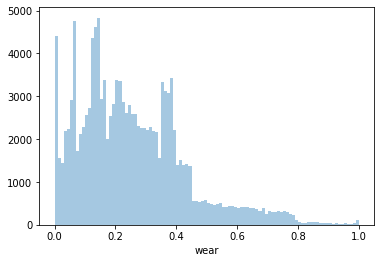

In [36]:
#distribution plot
#distribution for 1 var

sns.distplot(data['wear'], kde = False)# , bins=100)
#balken sind histogram
#linie ist "kernal density estimation" false

In [38]:
#Joint Plot
#compare 2 distribution

sns.jointplot(x='salePrice', y= 'wear', data = data, kind = 'reg')
# kind = kde: estimates the distribution of data
# kind = hex


Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f73dbdaa050> (for post_execute):


KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7f73daca4e60> (for post_execute):


KeyboardInterrupt: ignored

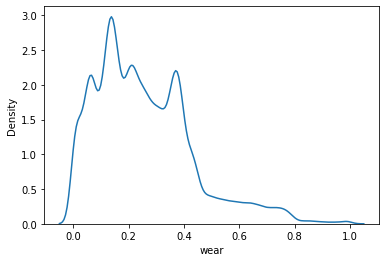

In [42]:
#kde plot
sns.kdeplot(data['wear'])

In [43]:
#pair plots
# hier sieht man, wie numerische vars sich verhalten gegenseitig
sns.pairplot(data)

KeyboardInterrupt: ignored

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f73dbdaa050> (for post_execute):


KeyboardInterrupt: ignored

Error in callback <function flush_figures at 0x7f73daca4e60> (for post_execute):


KeyboardInterrupt: ignored

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


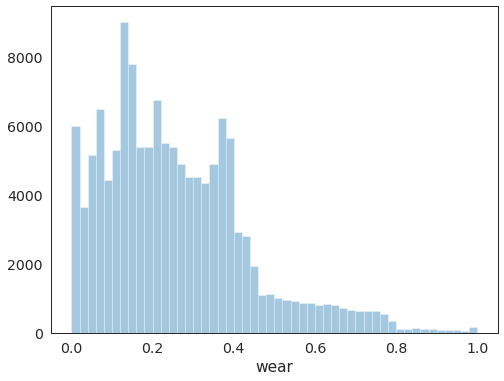

In [65]:
sns.set_style('white')
plt.figure(figsize=(8,6))

sns.set_context('paper', font_scale=1.6)

sns.distplot(data['wear'], kde = False)

#sns.despine(left=False, bottom = False)

In [ ]:
##kategorialssss

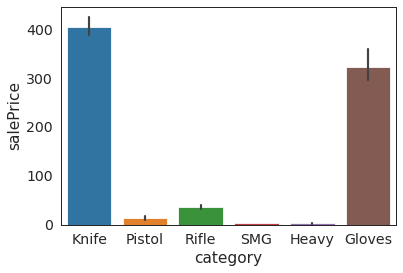

In [69]:
#barplot
sns.barplot(x='category', y='salePrice', data=data)

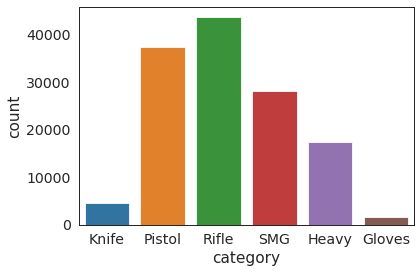

In [70]:
#countplot
sns.countplot(x='category', data=data) #selten?

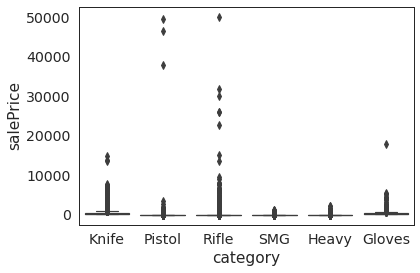

In [79]:
#boxplot. herausfinden warum komisch 

sns.boxplot(x='category', y='salePrice', data=data)

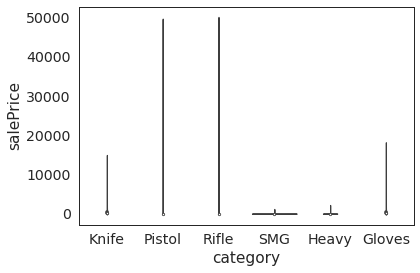

In [80]:
sns.violinplot(x='category', y='salePrice', data=data)

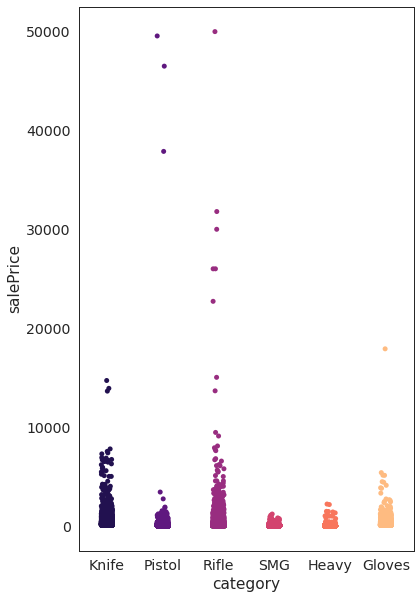

In [88]:
plt.figure(figsize=(6,10))

sns.stripplot(x='category', y='salePrice', data=data, jitter=True, palette = 'magma')

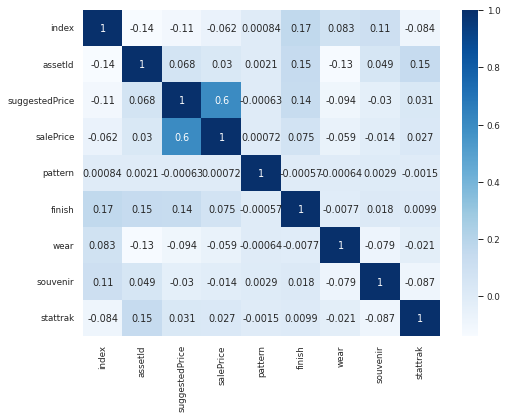

In [89]:
#heatmaps
plt.figure(figsize=(8,6))
sns.set_context('paper')

data_mx = data.corr()

sns.heatmap(data_mx, annot=True, cmap='Blues')

In [ ]:
preise = data.pivot_table(index='category', columns='wear', values = 'salePrice')
preise

###Balanced Data?

In [ ]:
data.category.value_counts()
# 1 :  2,9  :    10,8  : 17,4 :  23,1  : 27,1
#-> 1:27,1

Rifle     43665
Pistol    37346
SMG       28128
Heavy     17465
Knife      4604
Gloves     1614
Name: category, dtype: int64

Nova                 5979
PP-Bizon             5753
AUG                  5604
AK-47                5376
P250                 5340
                     ... 
Paracord Knife        105
Skeleton Knife        105
Survival Knife         85
Bloodhound Gloves      77
Nomad Knife            53
Name: subCategory, Length: 61, dtype: int64

###Strategie Datenaufbereitung für Modelle:


- assetId: passt
- family: eig zu viel
- color: Datentyp ändern, auf int64 umstellen, 4 Ausprägungen
- lock: passt
- version: genauer angucken, villeicht one hot encoding?
- versionType: kann man eig rausschmeißen, ist überordnung von version
- suggestedPrice: passt
- salePrice: passt
- Category: One Hot Encoding
- subCategory: viele ausprägungen... ohe?
- pattern: passt
- finish: passt
- wear: passt
- type: gute allg. Beschreibung, vollständig.. ohe?
- exterior: lable encoding
- quality: lable encoding
- rarity: lable encoding
- collection: nochmal angucken, ohe?
- stickers: passt
- souvenir: passt
- stattrack: passt

wenn zu viel OHE, dann frequency-encoding probieren?
https://medium.com/swlh/stop-one-hot-encoding-your-categorical-features-avoid-curse-of-dimensionality-16743c32cea4
"The frequency distribution of the column Country can be generated using the pandas' function: data[‘country’].value_counts()
Now replace each of the categories with their frequency in the data, for example, United States will be replaced by 7768, Russia by 1161. This technique is very each to implement and is a tremendously popular technique amongst Kagglers.
The downside of using this technique, if some categories have the same count, then they will be treated similarly by the model, hence losing some information."

####Daten in richriges Format bringen

numpy.float64

In [ ]:
data.shape

(133005, 22)

In [28]:
data.describe()

,index,assetId,suggestedPrice,salePrice,pattern,finish,wear,souvenir,stattrak
count,132822.000000,1.328220e+05,132822.000000,132822.000000,132822.000000,132822.000000,132822.000000,132822.000000,132822.000000
mean,66580.896501,4.724622e+07,29.443286,34.422234,500.392533,647.262283,0.255292,0.063988,0.099991
std,38352.754248,1.329716e+07,202.335509,372.976511,288.729975,1106.288792,0.177134,0.244732,0.299989
min,0.000000,1.240700e+04,0.030000,0.020000,0.000000,2.000000,0.000007,0.000000,0.000000
25%,33377.250000,3.878514e+07,0.030000,0.030000,250.000000,136.000000,0.125445,0.000000,0.000000
50%,66583.500000,5.176906e+07,0.100000,0.120000,500.000000,611.000000,0.223606,0.000000,0.000000
75%,99792.750000,5.838940e+07,1.590000,3.000000,751.000000,841.000000,0.361484,0.000000,0.000000
max,133004.000000,6.096650e+07,16609.350000,49999.990000,1000.000000,10088.000000,0.999827,1.000000,1.000000


In [29]:
data.category.describe()

count     132822
unique         6
top        Rifle
freq       43665
Name: category, dtype: object

In [30]:
data.category.value_counts()

Rifle     43665
Pistol    37346
SMG       28128
Heavy     17465
Knife      4604
Gloves     1614
Name: category, dtype: int64

In [ ]:
data.corr()
'''Die Untersuchung bivariater Beziehungen ist nützlich, wenn Sie ein Ergebnis oder eine abhängige 
Variable im Auge haben und die Merkmale sehen möchten, die am stärksten mit der Zunahme oder Abnahme 
des Ergebnisses korrelieren. Sie können bivariate Beziehungen mit Hilfe von Streudiagrammen visuell 
darstellen (siehe unten im Abschnitt über die Darstellung).'''

,assetId,suggestedPrice,salePrice,pattern,finish,wear,souvenir,stattrak
assetId,1.000000,0.068925,0.030860,0.002147,0.148031,-0.133814,0.048783,0.145395
suggestedPrice,0.068925,1.000000,0.601326,-0.000339,0.139428,-0.092672,-0.030024,0.031478
salePrice,0.030860,0.601326,1.000000,0.000858,0.075266,-0.059053,-0.013972,0.027527
pattern,0.002147,-0.000339,0.000858,1.000000,-0.000575,-0.000563,0.002910,-0.001460
finish,0.148031,0.139428,0.075266,-0.000575,1.000000,-0.007651,0.017888,0.009874
wear,-0.133814,-0.092672,-0.059053,-0.000563,-0.007651,1.000000,-0.079354,-0.021019
souvenir,0.048783,-0.030024,-0.013972,0.002910,0.017888,-0.079354,1.000000,-0.087119
stattrak,0.145395,0.031478,0.027527,-0.001460,0.009874,-0.021019,-0.087119,1.000000


In [32]:
data.groupby('category')['salePrice'].median()

category
Gloves    161.915
Heavy       0.040
Knife     235.000
Pistol      0.220
Rifle       0.350
SMG         0.040
Name: salePrice, dtype: float64

#Ausprobiertes

In [33]:
data.assetId[0]

46917102

In [ ]:
data.subCategory[0]

'Bayonet'

In [ ]:
data.family[0]

'Tiger Tooth'

In [ ]:
data.type[0]

'★ Covert Knife'

In [ ]:
data.stickers[11300]

"[{'sticker_id': None, 'wear': None, 'img': 'https://steamcdn-a.akamaihd.net/apps/730/icons/econ/stickers/community02/thuglife.a74c2a8f127182e257ff19650bb087aeee954bb3.png', 'name': 'Thug Life', 'type': None, 'slot': 1, 'color': None, 'name_localized': 'Thug Life', 'type_localized': None}, {'sticker_id': None, 'wear': None, 'img': 'https://steamcdn-a.akamaihd.net/apps/730/icons/econ/stickers/community02/thuglife.a74c2a8f127182e257ff19650bb087aeee954bb3.png', 'name': 'Thug Life', 'type': None, 'slot': 3, 'color': None, 'name_localized': 'Thug Life', 'type_localized': None}]"

In [ ]:
data.stattrak[11300]

True

In [ ]:
url = "https://cdn.skinport.com/images/screenshots/46917102/playside_256x128.png"

In [ ]:
im = Image.open(requests.get(url, stream=True).raw)

In [ ]:
rgb_image = im.convert('RGB')

In [ ]:
pix = np.array(rgb_image)

In [ ]:
pix.shape

(128, 256, 3)

In [ ]:
def image_colorfulness(image):
	# split the image into its respective RGB components
	(B, G, R) = cv2.split(image.astype("float"))
	# compute rg = R - G
	rg = np.absolute(R - G)
	# compute yb = 0.5 * (R + G) - B
	yb = np.absolute(0.5 * (R + G) - B)
	# compute the mean and standard deviation of both `rg` and `yb`
	(rbMean, rbStd) = (np.mean(rg), np.std(rg))
	(ybMean, ybStd) = (np.mean(yb), np.std(yb))
	# combine the mean and standard deviations
	stdRoot = np.sqrt((rbStd ** 2) + (ybStd ** 2))
	meanRoot = np.sqrt((rbMean ** 2) + (ybMean ** 2))
	# derive the "colorfulness" metric and return it
	return stdRoot + (0.3 * meanRoot)

In [ ]:
result = image_colorfulness(pix)

In [ ]:
result

59.79024317069133

###Bild im Loop

In [34]:
def image_colorfulness(image):
	# split the image into its respective RGB components
	(B, G, R) = cv2.split(image.astype("float"))
	# compute rg = R - G
	rg = np.absolute(R - G)
	# compute yb = 0.5 * (R + G) - B
	yb = np.absolute(0.5 * (R + G) - B)
	# compute the mean and standard deviation of both `rg` and `yb`
	(rbMean, rbStd) = (np.mean(rg), np.std(rg))
	(ybMean, ybStd) = (np.mean(yb), np.std(yb))
	# combine the mean and standard deviations
	stdRoot = np.sqrt((rbStd ** 2) + (ybStd ** 2))
	meanRoot = np.sqrt((rbMean ** 2) + (ybMean ** 2))
	# derive the "colorfulness" metric and return it
	return stdRoot + (0.3 * meanRoot)

In [54]:
data['colorfulness'] = ''

In [58]:
for x in range(len(data)):
  url = "https://cdn.skinport.com/images/screenshots/" + str(data.assetId[x]) + "/playside_256x128.png"
  im = Image.open(requests.get(url, stream=True).raw)
  rgb_image = im.convert('RGB')
  pix = np.array(rgb_image)
  result = image_colorfulness(pix)
  data.colorfulness[x] = result
  time.sleep(3)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


KeyboardInterrupt: ignored

In [62]:
data.colorfulness.head(50)

0     59.790243
1     57.181995
2     58.160273
3     58.489647
4     60.797777
5     58.559667
6     58.914031
7     58.696122
8     60.621316
9     58.159267
10    58.369062
11    59.173909
12    13.085045
13    29.679235
14     9.534625
15     6.577439
16    32.268612
17     8.250027
18    52.762477
19     23.57286
20    14.624531
21    53.859783
22     11.96748
23    11.413398
24    16.012754
25    10.241787
26     6.714524
27    53.503195
28    14.448246
29    24.973458
30    11.852063
31    16.217127
32     30.91391
33     9.120786
34    52.397508
35    27.127597
36    16.484866
37    12.869886
38    11.545369
39    12.974394
40    27.308249
41    10.279848
42     7.660004
43     9.599427
44    53.040026
45    22.378888
46     6.826276
47     13.79391
48    12.991382
49    23.356854
Name: colorfulness, dtype: object

In [128]:
url = "https://cdn.skinport.com/images/screenshots/55026078/playside_256x128.png"

In [129]:
im = Image.open(requests.get(url, stream=True).raw)

In [130]:
rgb_image = im.convert('RGB')

In [131]:
pix = np.array(rgb_image)

In [51]:
pix.shape

(128, 256, 3)

In [132]:
result = image_colorfulness(pix)

In [133]:
result

17.26810768559951

In [127]:
data2.assetId[6085]

55026078

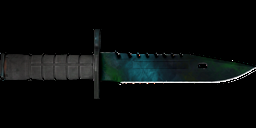

In [126]:
rgb_image

In [100]:
len(data2)

133005